# Proyecto Machine Learning: Predicción de Churn - Aurelion V2.0

**Autor:** Fundamentos de IA - IBM SkillsBuild & Guayerd  
**Fecha:** 2025-11-28  
**Metodología:** CRISP-DM (Clases 10 y 11)  
**Dataset:** clean_sales.csv (Solo Clientes Activos)

---

## 🎯 Objetivos del Proyecto

1. **Análisis Exploratorio** de datos transaccionales
2. **Foco en Clientes Activos** (67 clientes con compras)
3. **Ingeniería de Características** (RFM + T)
4. **Modelo de Clasificación** (Regresión Logística)
5. **Evaluación y Segmentación** por nivel de riesgo

### ℹ️ Nota de Versión
- Esta versión **V2.0** analiza exclusivamente a los **67 clientes** que han realizado compras.
- Sirve como **línea base** para comparar con la versión V2.1 (que incluye inactivos).


---
## 1. Importación de Librerías


In [83]:
# Manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

# Utilidades
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


---
## 2. Carga de Datos

### 2.1 Dataset Transaccional (clean_sales.csv)


In [84]:
# Cargar ventas
df_sales = pd.read_csv('../../../segunda-demo/output/clean_sales.csv')
df_sales['fecha'] = pd.to_datetime(df_sales['fecha'])
df_sales['fecha_alta'] = pd.to_datetime(df_sales['fecha_alta'])

print("📊 Dataset de Ventas cargado")
print(f"Dimensiones: {df_sales.shape[0]} transacciones x {df_sales.shape[1]} columnas")
print(f"Clientes con compras: {df_sales['id_cliente'].nunique()}\n")
df_sales.head()


📊 Dataset de Ventas cargado
Dimensiones: 343 transacciones x 14 columnas
Clientes con compras: 67



,id_venta,fecha,id_cliente,medio_pago,id_producto,cantidad,importe,nombre_producto,categoria,precio_unitario,nombre_cliente,email,ciudad,fecha_alta
0,1,2024-06-19,62,tarjeta,90,1,2902,Toallas Húmedas x50,Limpieza,2902,Guadalupe Romero,guadalupe.romero@mail.com,Carlos Paz,2023-03-03
1,2,2024-03-17,49,qr,82,5,11970,Aceitunas Negras 200g,Alimentos,2394,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
2,2,2024-03-17,49,qr,39,5,2345,Helado Vainilla 1L,Alimentos,469,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
3,2,2024-03-17,49,qr,70,2,8122,Fernet 750ml,Alimentos,4061,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
4,2,2024-03-17,49,qr,22,1,2069,Medialunas de Manteca,Alimentos,2069,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18


### 2.2 Análisis Exploratorio Inicial


In [85]:
# Información clave
fecha_corte = df_sales['fecha'].max()
print("🔍 ANÁLISIS EXPLORATORIO\n" + "="*60)
print(f"\n📅 Periodo de datos:")
print(f"   Fecha mínima: {df_sales['fecha'].min().date()}")
print(f"   Fecha máxima: {fecha_corte.date()}")
print(f"   Días de historial: {(fecha_corte - df_sales['fecha'].min()).days}")

print(f"\n💰 Ventas:")
print(f"   Importe total: ${df_sales['importe'].sum():,.2f}")
print(f"   Ticket promedio: ${df_sales.groupby('id_venta')['importe'].sum().mean():,.2f}")

print(f"\n🏙️ Ciudades:")
print(df_sales['ciudad'].value_counts())


🔍 ANÁLISIS EXPLORATORIO

📅 Periodo de datos:
   Fecha mínima: 2024-01-02
   Fecha máxima: 2024-06-28
   Días de historial: 178

💰 Ventas:
   Importe total: $2,651,417.00
   Ticket promedio: $22,095.14

🏙️ Ciudades:
ciudad
Rio Cuarto     104
Alta Gracia     65
Cordoba         65
Carlos Paz      41
Mendiolaza      34
Villa Maria     34
Name: count, dtype: int64


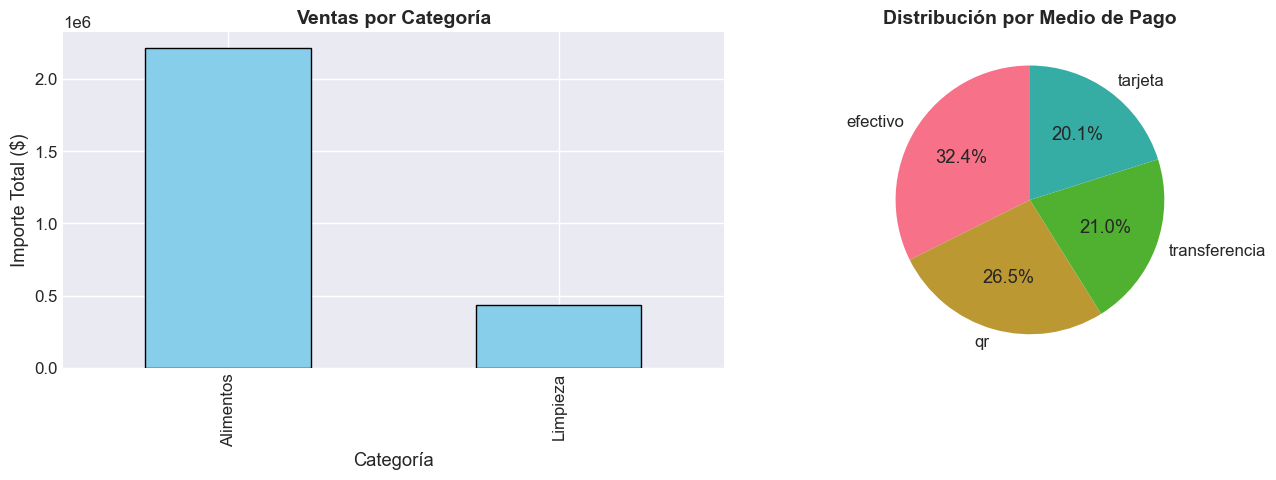

In [86]:
# Visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ventas por categoría
cat_ventas = df_sales.groupby('categoria')['importe'].sum().sort_values(ascending=False)
cat_ventas.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Ventas por Categoría', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Importe Total ($)')

# Medio de pago
medio = df_sales['medio_pago'].value_counts()
medio.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribución por Medio de Pago', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


---
## 3. Ingeniería de Características (Feature Engineering)

### 3.1 Métricas RFM + T para Clientes con Compras


In [87]:
# Calcular RFM para clientes con compras
rfm_activos = df_sales.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_corte - x.max()).days,
    'id_venta': 'nunique',
    'importe': 'sum',
    'cantidad': 'sum',
    'fecha_alta': 'first',
    'nombre_cliente': 'first',
    'email': 'first',
    'ciudad': 'first'
}).reset_index()

rfm_activos.columns = ['id_cliente', 'recencia_dias', 'frecuencia_compras',
                        'monetario_total', 'total_articulos', 'fecha_alta',
                        'nombre_cliente', 'email', 'ciudad']

rfm_activos['antiguedad_dias'] = (fecha_corte - rfm_activos['fecha_alta']).dt.days
rfm_activos['ticket_promedio'] = rfm_activos['monetario_total'] / rfm_activos['frecuencia_compras']
rfm_activos['ha_comprado'] = 1

print(f"✅ RFM calculado para {len(rfm_activos)} clientes con compras\n")
rfm_activos.head()


✅ RFM calculado para 67 clientes con compras



,id_cliente,recencia_dias,frecuencia_compras,monetario_total,total_articulos,fecha_alta,nombre_cliente,email,ciudad,antiguedad_dias,ticket_promedio,ha_comprado
0,1,94,2,72448,26,2023-01-01,Mariana Lopez,mariana.lopez@mail.com,Carlos Paz,544,36224.0,1
1,2,77,1,22150,5,2023-01-02,Nicolas Rojas,nicolas.rojas@mail.com,Carlos Paz,543,22150.0,1
2,3,133,1,33310,15,2023-01-03,Hernan Martinez,hernan.martinez@mail.com,Rio Cuarto,542,33310.0,1
3,5,3,4,132158,50,2023-01-05,Agustina Flores,agustina.flores@mail.com,Cordoba,540,33039.5,1
4,6,136,2,48878,14,2023-01-06,Uma Medina,uma.medina@mail.com,Villa Maria,539,24439.0,1


### 3.2 Definición del Target (Churn)

**Regla de Negocio:**
- **Churn (1):** Sin compras en los últimos 90 días.
- **No Churn (0):** Con compras en los últimos 90 días.


In [88]:
# Definir Churn (90 días sin compra)
rfm_activos['churn'] = rfm_activos['recencia_dias'].apply(lambda x: 1 if x > 90 else 0)

print("📊 Distribución de Churn (67 Clientes):")
print(rfm_activos['churn'].value_counts())
print(f"\nTasa de Churn: {rfm_activos['churn'].mean()*100:.1f}%")


📊 Distribución de Churn (67 Clientes):
churn
0    36
1    31
Name: count, dtype: int64

Tasa de Churn: 46.3%


---
## 4. Preprocesamiento de Datos

**Selección de Features:**
- `frecuencia_compras`
- `monetario_total`
- `total_articulos`
- `antiguedad_dias`
- `ticket_promedio`

⚠️ **Nota:** Se excluye `recencia_dias` del entrenamiento para evitar **Data Leakage**, ya que el target se construyó directamente con esta variable.


In [89]:
# Selección de features (Excluyendo recencia_dias)
features = ['frecuencia_compras', 'monetario_total', 'total_articulos', 'antiguedad_dias', 'ticket_promedio']
X = rfm_activos[features]
y = rfm_activos['churn']

# Escalado de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Datos preprocesados y divididos")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


✅ Datos preprocesados y divididos
Train shape: (53, 5)
Test shape: (14, 5)


---
## 5. Modelo de Clasificación (Regresión Logística)


In [90]:
# Entrenar modelo
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("✅ Modelo entrenado correctamente")


✅ Modelo entrenado correctamente


---
## 6. Evaluación del Modelo


📊 Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.60      0.50      0.55         6

    accuracy                           0.64        14
   macro avg       0.63      0.62      0.63        14
weighted avg       0.64      0.64      0.64        14


🔢 Matriz de Confusión:


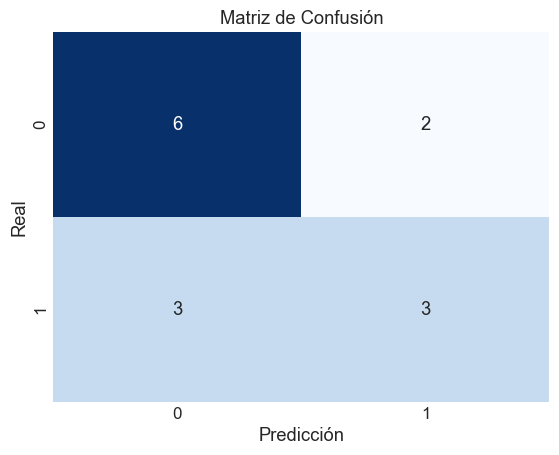

In [91]:
print("📊 Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

print("\n🔢 Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [92]:
# Calcular métricas para el resumen final
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


---
## 7. Análisis de Clientes en Riesgo

### 7.1 Predicción para Todos los Clientes


In [93]:
# Predecir para todos
X_full = scaler.transform(X)
prob_churn = model.predict_proba(X_full)[:, 1]

rfm_activos['prob_churn'] = prob_churn * 100
rfm_activos['pred_churn'] = model.predict(X_full)

print(f"✅ Predicciones para {len(rfm_activos)} clientes")
print(f"   Predichos Churn: {rfm_activos['pred_churn'].sum()}")
print(f"   Predichos Activos: {(rfm_activos['pred_churn']==0).sum()}")


✅ Predicciones para 67 clientes
   Predichos Churn: 34
   Predichos Activos: 33


### 7.2 Segmentación por Riesgo


In [94]:
# Clasificar por riesgo
def clasificar_riesgo(prob):
    if prob >= 70: return 'Alto'
    elif prob >= 40: return 'Medio'
    elif prob >= 20: return 'Bajo'
    else: return 'Ideal'

rfm_activos['nivel_riesgo'] = rfm_activos['prob_churn'].apply(clasificar_riesgo)

resumen = rfm_activos.groupby('nivel_riesgo').agg({
    'id_cliente': 'count',
    'monetario_total': 'sum'
}).rename(columns={'id_cliente': 'cantidad', 'monetario_total': 'valor_total'})
resumen['porcentaje'] = (resumen['cantidad'] / len(rfm_activos)) * 100
resumen = resumen.reindex(['Ideal', 'Bajo', 'Medio', 'Alto'])

print("📊 RESUMEN POR RIESGO\n" + "="*70)
print(resumen)


📊 RESUMEN POR RIESGO
              cantidad  valor_total  porcentaje
nivel_riesgo                                   
Ideal                7       574806       10.45
Bajo                14       785555       20.90
Medio               36      1126132       53.73
Alto                10       164924       14.93


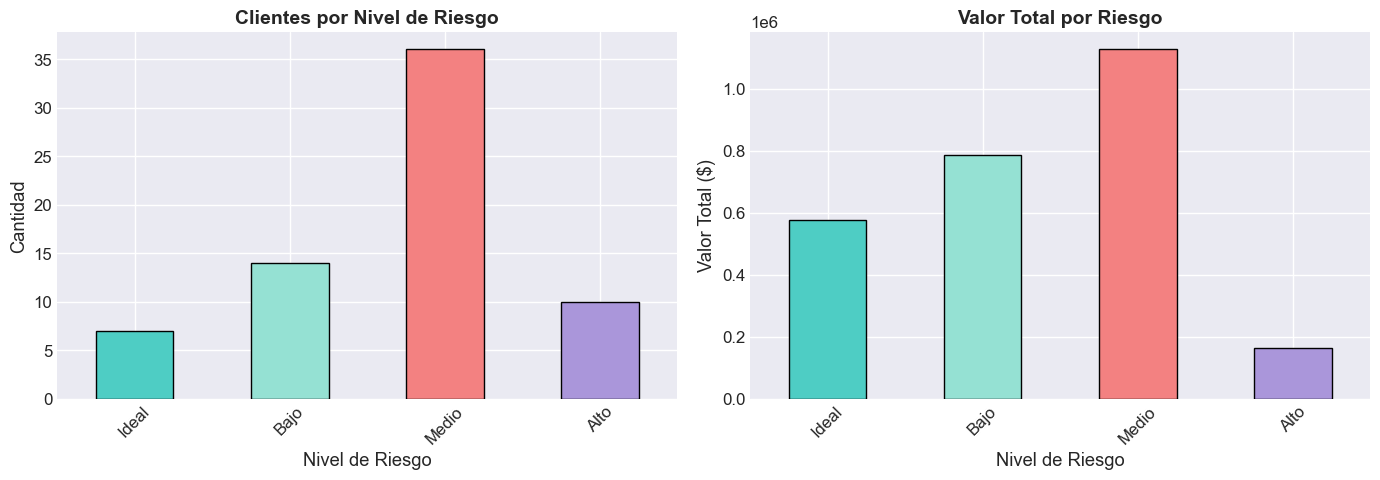

In [95]:
# Visualizar segmentación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

resumen['cantidad'].plot(kind='bar', ax=axes[0], color=['#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'], edgecolor='black')
axes[0].set_title('Clientes por Nivel de Riesgo', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nivel de Riesgo')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=45)

resumen['valor_total'].plot(kind='bar', ax=axes[1], color=['#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'], edgecolor='black')
axes[1].set_title('Valor Total por Riesgo', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nivel de Riesgo')
axes[1].set_ylabel('Valor Total ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 7.3 Top Clientes en Riesgo Alto


In [96]:
# Clientes de riesgo alto
alto_riesgo = rfm_activos[rfm_activos['nivel_riesgo']=='Alto'].sort_values('prob_churn', ascending=False)

print(f"⚠️  CLIENTES DE RIESGO ALTO: {len(alto_riesgo)}\n" + "="*100)
cols = ['id_cliente', 'nombre_cliente', 'recencia_dias', 'frecuencia_compras', 'monetario_total', 'ha_comprado', 'prob_churn']
print(alto_riesgo[cols].head(15).to_string(index=False))


⚠️  CLIENTES DE RIESGO ALTO: 10
 id_cliente   nombre_cliente  recencia_dias  frecuencia_compras  monetario_total  ha_comprado  prob_churn
         17      Pablo Gomez            162                   1             7752            1       77.50
         29  Diego Fernandez            112                   1             4283            1       77.12
         13    Ivana Sanchez             59                   1            13188            1       75.27
          2    Nicolas Rojas             77                   1            22150            1       74.18
         18     Ivana Torres             91                   1            20544            1       72.38
         21  Elena Rodriguez            128                   1            20048            1       72.37
         10    Karina Acosta              9                   1            25860            1       71.62
         36   Martina Molina            122                   1            15966            1       71.28
         23 He

---
## 8. Guardado de Modelos y Resultados

### 8.1 Guardar Modelos


In [ ]:
# Guardar modelos
os.makedirs('../models', exist_ok=True)

with open('../models/churn_model_v2.0.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('../models/scaler_v2.0.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('../models/features_v2.0.pkl', 'wb') as f:
    pickle.dump(features, f)

print("💾 Modelos guardados:\n")
print("   ✅ churn_model_v2.0.pkl")
print("   ✅ scaler_v2.0.pkl")
print("   ✅ features_v2.0.pkl")


💾 Modelos guardados:

   ✅ churn_model_v2.pkl
   ✅ scaler_v2.pkl
   ✅ features_v2.pkl


### 8.2 Exportar Resultados


In [98]:
# Exportar CSVs
os.makedirs('../../output', exist_ok=True)

alto_export = alto_riesgo[['id_cliente', 'nombre_cliente', 'email', 'ciudad', 
                           'recencia_dias', 'frecuencia_compras', 'monetario_total',
                           'ha_comprado', 'prob_churn', 'nivel_riesgo']]
alto_export.to_csv('../../output/clientes_riesgo_alto_v2.csv', index=False)
resumen.to_csv('../../output/resumen_ejecutivo_v2.csv')

print("📊 Resultados exportados:\n")
print("   ✅ clientes_riesgo_alto_v2.csv")
print("   ✅ resumen_ejecutivo_v2.csv")


📊 Resultados exportados:

   ✅ clientes_riesgo_alto_v2.csv
   ✅ resumen_ejecutivo_v2.csv


---
## 9. Conclusiones

### 9.1 Resumen Final


In [99]:
# Resumen final
print("="*80)
print("📋 RESUMEN FINAL DEL PROYECTO")
print("="*80)
print(f"\n🎯 MODELO")
print(f"  Algoritmo: Regresión Logística")
print(f"  Accuracy: {accuracy:.2%}")
print(f"  Precision: {precision:.2%}")
print(f"  Recall: {recall:.2%}")
print(f"  F1-Score: {f1:.2%}")
print(f"\n📊 DATASET")
print(f"  Total clientes: {len(rfm_activos)}")
print(f"  Con compras: {rfm_activos['ha_comprado'].sum()}")
print(f"  Sin compras: {(rfm_activos['ha_comprado']==0).sum()}")
print(f"\n⚠️  RIESGO")
for nivel in ['Ideal', 'Bajo', 'Medio', 'Alto']:
    if nivel in resumen.index:
        print(f"  {nivel:8s}: {resumen.loc[nivel, 'cantidad']:3.0f} clientes - ${resumen.loc[nivel, 'valor_total']:,.2f}")
print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO")
print("="*80)


📋 RESUMEN FINAL DEL PROYECTO

🎯 MODELO
  Algoritmo: Regresión Logística
  Accuracy: 64.29%
  Precision: 60.00%
  Recall: 50.00%
  F1-Score: 54.55%

📊 DATASET
  Total clientes: 67
  Con compras: 67
  Sin compras: 0

⚠️  RIESGO
  Ideal   :   7 clientes - $574,806.00
  Bajo    :  14 clientes - $785,555.00
  Medio   :  36 clientes - $1,126,132.00
  Alto    :  10 clientes - $164,924.00

✅ ANÁLISIS COMPLETADO


### 9.2 Recomendaciones

**Acciones Inmediatas**:
1. 🎯 Contactar clientes de riesgo alto
2. 💰 Ofertas personalizadas
3. 📧 Campaña de reactivación

**Estrategias**:
1. 📊 Dashboard en tiempo real
2. 🔄 Programa de lealtad
3. 📱 Alertas automáticas

**Mejoras Técnicas**:
1. 🔬 Más datos históricos
2. 🎯 Nuevas features
3. 🤖 Modelos avanzados (Random Forest, XGBoost)

---

**Fin del Notebook** 🎉
